In [41]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import os
from sklearn.metrics import mean_squared_error

In [42]:
channels = ['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7'
            , 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz'
            , 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2','AUX_1', 'ACC_X', 'ACC_Y', 'ACC_Z']
removed_channels = ['Fp1', 'F8', 'F7', 'Fp2', 'F3', 'F4']
# TODO ADD AUX WHEN CONNECTED
eye_data_names = ['x', 'y', 'z', 'left_blink', 'right_blink', 'both_blink', 'left_openness', 'right_openness']

columns =  eye_data_names + channels

data, header = pyxdf.load_xdf('data/LSLDataV2/LSLDataLeftFourTimes2/eeg-and-eyetracking.xdf')


In [43]:
def get_time_stamps(stamps: list):
    start = []
    end = []
    more_than_one = False

    for i in range(len(stamps)):
        if i == (len(stamps)-1):
            if(stamps[i-1] == (stamps[i] - 1)):
                end.append(stamps[i])
            break

        if(stamps[i] == (stamps[i+1] - 1)):
            if not more_than_one:
                start.append(stamps[i])
            more_than_one = True
            continue
        else:
            if more_than_one:
                end.append(stamps[i])
                more_than_one = False

    return start, end

In [44]:
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    axis.plot(df_ts['time'][start-rang:end+rang], (df_norm + plus) *(-1 if flip else 1) *scale, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Amplitude ")
    axis.set_title(column)
    plt.legend()
    plt.show()

def plot_eeg_blink_single(df,df_ts, start, end,column,rang = 50):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")

    axis.plot(df_ts['time'][start-rang:end+rang], df[column], label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], df['left_openness'], color='orange', label = "Eye openness left - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], df['right_openness'], color='violet', label = "Eye openness right - SRanipal")
    axis.set_title(column)
    plt.legend()
    plt.show()

In [45]:

def init_data(data, shift = 0):
    for s in data:
        stream = s
        y = stream['time_series']
        df_stream = pd.DataFrame(y)
        df_stream_ts = pd.DataFrame(stream['time_stamps'])
        df_stream_ts.columns = ['time']
        df_stream.columns = columns
        df_stream['AUX_1'] = df_stream['AUX_1']+ 1000000
        if shift != 0:
            df_stream['AUX_1'] = df_stream['AUX_1'].shift(shift)
        return stream, df_stream, df_stream_ts

stream, df_stream, df_stream_ts = init_data(data)
def get_blinks_in_df(df):
    left_blinks = df.index[(df['left_blink'] >= 1) & (df['right_blink'] != 1)].tolist()
    right_blinks = df.index[(df['right_blink'] >= 1) & (df['left_blink'] != 1)].tolist()
    both_blink = df.index[df['both_blink'] == 1].tolist()
    return left_blinks,right_blinks, both_blink

left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)

In [46]:
avg_time = np.diff(df_stream_ts.to_numpy().flatten()).tolist()

In [47]:
start, end = get_time_stamps(left_blinks)
flip = False
chosen_channel = 'AUX_1'
print(start)
print(end)


[1201, 1510, 1858]
[1278, 1576, 1917]


In [48]:
from scipy.signal import butter, lfilter
# Sample rate and desired cutoff frequencies (in Hz).
def plot_eeg_blink_single_norm(df,df_ts, start, end,column,rang = 50, scale=1, flip = False, order = 4):
    plt.figure(figsize=(10,6))
    df = df[start - rang:end + rang]
    df.columns = columns
    axis = plt.subplot()
    axis.axvline(df_ts['time'][start], color='green', label = "Blink start - TobiiXR")  # y = 0
    axis.axvline(df_ts['time'][end], color='red', label = "Blink End - TobiiXR")
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]

    y = (df_norm + plus) *(-1 if flip else 1) *scale
    peaks, _ = signal.find_peaks(y[rang-7:rang+30])
    peaks = [peak + rang-7 for peak in peaks]

    axis.plot(df_ts['time'][start-rang:end+rang], y, label = "EMG")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['left_openness'] / df['left_openness'].abs().max())
               *(-1)+ 1, color='orange', label = "Eye openness - SRanipal")
    axis.plot(df_ts['time'][start-rang:end+rang], (df['right_openness'] / df['right_openness'].abs().max())
               *(-1)+ 1, color='violet', label = "Eye openness right - SRanipal")
    axis.set_xlabel("Time normalized (seconds)")
    axis.set_ylabel("Normalized Amplitude")
    for i in peaks:
        plt.plot(df_ts['time'][i+ start - rang], y[i], marker="o", markersize=5, markeredgecolor="turquoise", markerfacecolor="black", label="Local maximum " + str(y[i].round(2)) + ", " + str(i+ start - rang))
    axis.set_title(column)
    plt.legend()
    plt.show()

def get_peaks(df, start, end, column, rang=50, scale=1, flip=False):
    df = df[start - rang:end + rang]
    df_norm = (df[column].abs() / df[column].abs().max())
    plus = -df_norm[start - rang]
    y = ((df_norm + plus) *(-1 if flip else 1) *scale).tolist()
    peaks, _ = signal.find_peaks(y[rang-20:rang+20])
    peaks = [peak + rang-20 for peak in peaks]
    if len(peaks) == 0:
        #print(df)
        return 0
    peak = peaks[np.argmax([y[i] for i in peaks])]+ start - rang
    return  peak if end + rang > peak > start - rang else start



In [49]:


def find_shift(start, peaks):
    differences_start = []
    differences_end = []
    for i in range(len(peaks)):
        differences_start.append(start[i]-peaks[i])
    return differences_start

def plot_table(df):
    #make this example reproducible

    #define figure and axes
    fig, ax = plt.subplots()
    #hide the axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    #create data

    #create table
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    table.scale(2.5, 2.5)
    table.set_fontsize(30)
    plt.show()

In [50]:

def run_files(paths, path='data/LSLGoodData/', both = True, plot = False, shift_init=0):
    peak_info = []
    avg_time = []
    for (index,y) in enumerate(paths):
        data, header = pyxdf.load_xdf(path+str(y)+'/dejittered-fir-eeg-and-dejittered-eyetracking.xdf')
        stream, df_stream, df_stream_ts = init_data(data,shift_init)
        left_blinks, right_blinks, both_blink = get_blinks_in_df(df_stream)
        start, end = get_time_stamps(both_blink if both else left_blinks)
        avg_time.append(np.diff(df_stream_ts.to_numpy().flatten()).tolist())
        peaks = []
        for i in range(len(start)):
            if i == 10:
                continue
            peaks.append(get_peaks(df_stream, start[i], end[i], chosen_channel, rang=50, scale=5, flip=both))

        shift = find_shift(start, peaks)
        peak_info.append(shift)

    n = len(max(peak_info, key=len))
    t = [x + [None]*(n-len(x)) for x in peak_info]
    numpy_array_peak_info = np.array(t)
    df_peak = pd.DataFrame(numpy_array_peak_info)
    df_peak = df_peak.set_index([paths])
    df_peak['time between index (s)'] = [i[0] for i in avg_time]
    df_peak['Sum (indexes)'] = df_peak.sum(axis=1)
    df_peak['Avg (indexes)'] = round(df_peak.loc[:, 0:9].mean(axis=1),3)
    df_peak['Avg time (ms)'] = round(df_peak['Avg (indexes)']*df_peak['time between index (s)'],5)*1000
    if plot:
        plot_table(df_peak)
    return df_peak



In [51]:


paths = [name for name in os.listdir("./data/LSLGoodData")]
both = [name for name in paths if "Both" in name]


df_both = run_files(both, both=True , plot=False)
#df_both = df_both.drop(df_both.columns[[1]], inplace=True, axis=1)
display(df_both)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
FK20LSLDataBothTenTimes5,-7,-5,-10,-4,-6,-4,-4,-8,-5,-7,0.008,-59.992,-6.000,-48.00
LSLDataBoth10Times1,-7,-4,-3,-4,-1,-7,-5,-5,-5,-4,0.008,-44.992,-4.500,-36.00
LSLDataBoth10Times10,-6,-6,-9,-5,-8,-4,-10,-6,-6,-9,0.008,-68.992,-6.900,-55.20
LSLDataBoth10Times11,-5,-6,-4,-5,-6,-5,-6,-5,-6,-10,0.008,-57.992,-5.800,-46.40
LSLDataBoth10Times12,-7,-6,-7,-4,-5,-4,-7,-5,-7,-8,0.008,-59.992,-6.000,-48.00
LSLDataBoth10Times13,-3,-6,-5,-3,-5,-3,-6,-4,-5,-6,0.008,-45.992,-4.600,-36.80
LSLDataBoth10Times14,-4,-4,-4,-6,-6,-8,-5,-9,-6,-8,0.008,-59.992,-6.000,-48.00
LSLDataBoth10Times2,-6,-4,-4,-4,-6,-2,-7,-5,-5,-6,0.008,-48.992,-4.900,-39.20
LSLDataBoth10Times3,-3,-6,-5,-6,-7,-6,-8,-2,-2,-8,0.008,-52.992,-5.300,-42.40
LSLDataBoth10Times4,-1,-4,-4,-5,-6,-3,-4,-6,-4,-4,0.008,-40.992,-4.100,-32.80


In [52]:
def get_offset(df):
    avg_offset = df['Avg time (ms)'].sum()/df.shape[0]
    avg_offset_index = df['Avg (indexes)'].sum()/df.shape[0]
    #print(avg_offset_index)
    return avg_offset, avg_offset_index


In [53]:
print("(ms, Number of indexes to shift) ---- Both")
print(get_offset(df_both))
df_both_shift = run_files(both, both=True , plot=False, shift_init=round(get_offset(df_both)[1]))
#df_both_shift.loc['Average']= df_both_shift.sum(numeric_only=True, axis=0)/df_both_shift.shape[0]
display(df_both_shift)


print(get_offset(df_both_shift))

(ms, Number of indexes to shift) ---- Both
(-41.050000000000004, -5.131259259259259)


,0,1,2,3,4,5,6,7,8,9,time between index (s),Sum (indexes),Avg (indexes),Avg time (ms)
FK20LSLDataBothTenTimes5,-2,0,-5,1,-1,1,1,-3,0,-2,0.008,-9.992,-1.000,-8.00
LSLDataBoth10Times1,-2,1,2,1,4,-2,0,0,0,1,0.008,5.008,0.500,4.00
LSLDataBoth10Times10,-1,-1,-4,0,-3,1,-5,-1,-1,-4,0.008,-18.992,-1.900,-15.20
LSLDataBoth10Times11,0,-1,1,0,-1,0,-1,0,-1,-5,0.008,-7.992,-0.800,-6.40
LSLDataBoth10Times12,-2,-1,-2,1,0,1,-2,0,-2,-3,0.008,-9.992,-1.000,-8.00
LSLDataBoth10Times13,2,-1,0,2,0,2,-1,1,0,-1,0.008,4.008,0.400,3.20
LSLDataBoth10Times14,1,1,1,-1,-1,-3,0,-4,-1,-3,0.008,-9.992,-1.000,-8.00
LSLDataBoth10Times2,-1,1,1,1,-1,3,-2,0,0,-1,0.008,1.008,0.100,0.80
LSLDataBoth10Times3,2,-1,0,-1,-2,-1,-3,3,3,-3,0.008,-2.992,-0.300,-2.40
LSLDataBoth10Times4,4,1,1,0,-1,2,1,-1,1,1,0.008,9.008,0.900,7.20


(-1.05, -0.13125925925925927)


In [54]:
import statistics
from scipy.stats import sem

standard_de_both = statistics.stdev(df_both['Avg time (ms)'])
se_both = sem(df_both['Avg time (ms)'])
print("Standard devation")
print("Both: " + str(standard_de_both))

print("-------- SE ----------")
print("Both: " + str(se_both))

Standard devation
Both: 6.197130229140184
-------- SE ----------
Both: 1.1926382686657506


In [56]:
standard_de_both_shift = statistics.stdev(df_both_shift['Avg time (ms)'])
se_both_shift = sem(df_both_shift['Avg time (ms)'])
print("Standard devation - After shift")
print("Both: " + str(standard_de_both_shift))
print("-------- SE - After shift ----------")
print("Both: " + str(se_both_shift))

Standard devation - After shift
Both: 6.197130229140185
-------- SE - After shift ----------
Both: 1.1926382686657508


[-0.152, -0.08, -0.08, -0.08, -0.07200000000000001, -0.07200000000000001, -0.064, -0.064, -0.048, -0.04, -0.035500000000000004, -0.032, -0.024, 0.008, 0.008, 0.016, 0.016, 0.016, 0.024, 0.032, 0.04, 0.04, 0.04, 0.055999999999999994, 0.07200000000000001, 0.07200000000000001, 0.12]


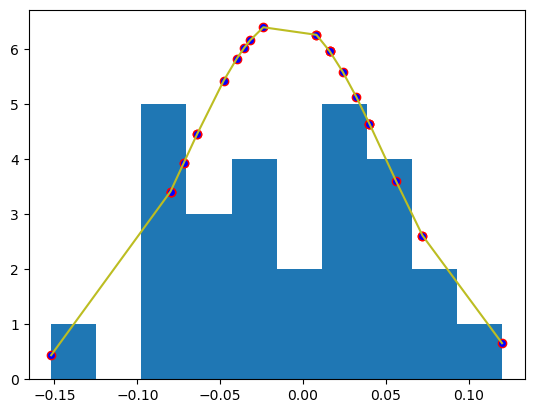

In [58]:
from scipy.stats import norm
# Plot between -10 and 10 with .001 steps.
x_axis = sorted((df_both_shift['Avg time (ms)']/100).tolist())
print(x_axis)

plt.hist(x_axis)
for i in range(len(x_axis)):
    plt.plot(x_axis[i],  norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis))[i], marker="o", markersize=6, markeredgecolor="red", markerfacecolor="blue")
plt.plot(x_axis, norm.pdf(x_axis,np.mean(x_axis),np.std(x_axis)))
plt.show()